In [1]:
import os
import random
from  tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torch.nn.init as init

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

from model import * #From model.py

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
transform = torchvision.transforms.ToTensor()

model_avail = True
model_path = "../../models_senc-dec/model_27.pth"
is_eval = True

def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


In [2]:
#Load data return data loaders
def LoadData(image_folder, annotation_csv):
	train_labeled_scene_index = np.arange(106, 131)
	val_labeled_scene_index = np.arange(131, 132)
	labeled_trainset = LabeledDataset(image_folder=image_folder, annotation_file=annotation_csv, 
		scene_index=train_labeled_scene_index, transform=transform, extra_info=True)

	labeled_valset = LabeledDataset(image_folder=image_folder, annotation_file=annotation_csv,
		scene_index=val_labeled_scene_index,transform=transform,extra_info=True)

	trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
	valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

	return trainloader, valloader

In [3]:
#ThreatScore - Determines Model Performance - Challenge Metric
def ThreatScore(true, pred):
	TP = 0
	FP = 0
	FN = 0
	n = len(true)
	for i in range(n):
		for j in range(n):
			if true[i][j] == True and pred[i][j] == True:
				TP += 1
			elif true[i][j] == False and pred[i][j] == True:
				FP += 1
			elif true[i][j] == True and pred[i][j] == False:
				FN += 1
	return TP/(TP+FP+FN)

def ComputeLoss(criterion, true, pred):
	loss = 0.0
	for i in range(800):
		for j in range(800):
			loss += criterion(true[:,:,i,j], pred[:,i,j])
	return loss

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=(2,3)),
            nn.ReLU(inplace=True),
            #Current Size:- 64 x 256 x 308
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Current Size:- 64 x 128 x 154
            nn.Conv2d(64, 192, kernel_size=3, padding=(1,2)),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            #Current Size:- 192 x 128 x 156
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 384 x 128 x 156
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            #Current Size:- 256 x 128 x 156
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Current Size:- 256 x 64 x 78
            nn.Conv2d(256, 192, kernel_size=(3,5), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            #Current Size:- 192 x 64 x 76
            nn.Conv2d(192, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 64 x 64 x 76
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 64 x 64 x 76
        )
        
    def forward(self,x):
        return self.encoder_features(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder_features = nn.Sequential(
        	nn.Upsample(size=(100,100), mode='bilinear', align_corners=True),
        	#Current Size:- 384 x 100 x 100
        	nn.ConvTranspose2d(384, 256, kernel_size=4, stride=2, padding=1),
        	nn.ReLU(inplace=True),
                nn.BatchNorm2d(256),
        	#Current Size:- 256 x 200 x 200
        	nn.Conv2d(256, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        	#Current Size:- 192 x 200 x 200
        	nn.ConvTranspose2d(192, 64, kernel_size=4, stride=2, padding=1),
        	nn.ReLU(inplace=True),
                nn.BatchNorm2d(64),
        	#Current Size:- 64 x 400 x 400
        	nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Current Size:- 32 x 400 x 400
        	nn.ConvTranspose2d(32, 1,kernel_size=4, stride=2, padding=1),
        	nn.ReLU(inplace=True),
        	#Current Size:- 1 x 800 x 800
        )
        
    def forward(self,x):
        return self.decoder_features(x)


class Encoder_Decoder(nn.Module):
    def __init__(self):
        super(Encoder_Decoder, self).__init__()
        #Input Size:- 3 x 256 x 306
        self.encoders = nn.ModuleList()
        for _ in range(6):
            self.encoders.append(Encoder())
        self.decoder = Decoder()

    def forward(self, x):
        x = x.permute(1,0,2,3,4)
        x = x-0.5
        encoder_outs = []
        for i in range(6):
            encoder_outs.append(self.encoders[i](x[i]))
        encoder_output = torch.stack(encoder_outs).permute(0,2,1,3,4)
        encoder_output = torch.cat([i for i in encoder_output]).permute(1,0,2,3)
        decoder_output = self.decoder(encoder_output)
        return decoder_output

  0%|          | 0/1 [00:00<?, ?it/s]

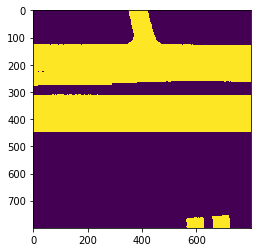

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


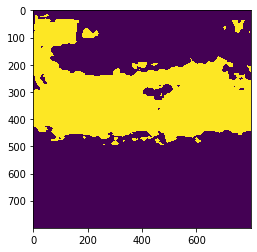

0.5167816076418572
Random TS: 
0.24757889405287273


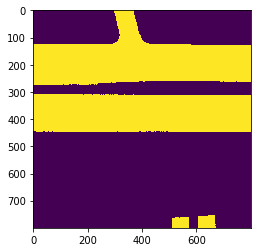

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


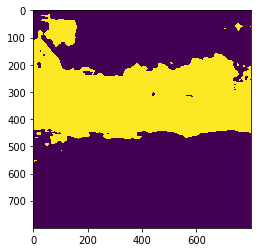

0.5467199474041049
Random TS: 
0.25210835705794565


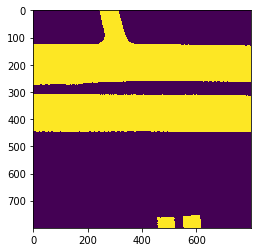

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


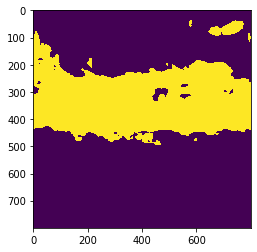

0.5185992767045956
Random TS: 
0.23471083881413496


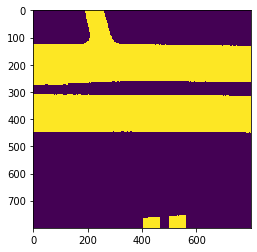

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


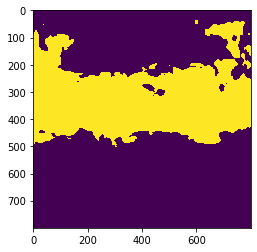

0.5177615489130435
Random TS: 
0.24825244516980768


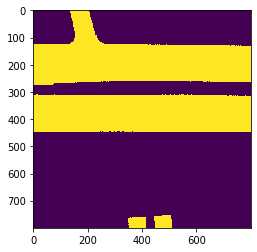

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


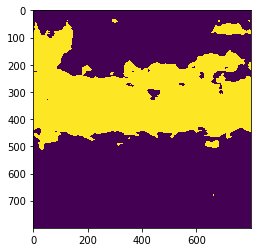

0.5416636658264314
Random TS: 
0.25231168600755893


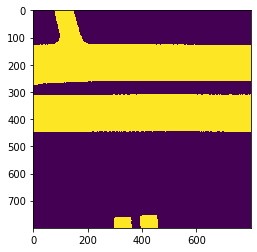

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


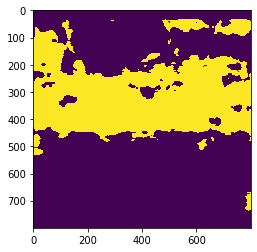

0.5313220204126426
Random TS: 
0.25107674762624765


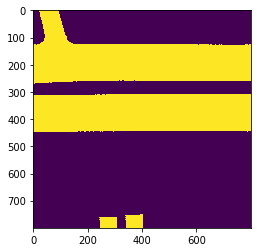

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


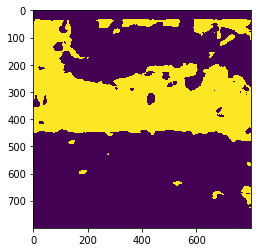

0.4891030647420015
Random TS: 
0.24791008491197575


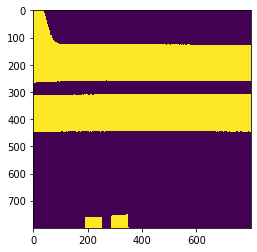

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


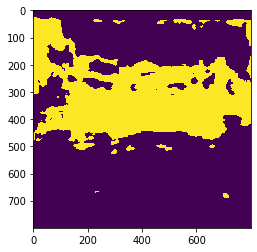

0.5319188231199256
Random TS: 
0.24059291961880347


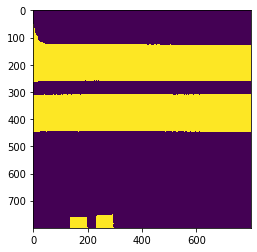

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


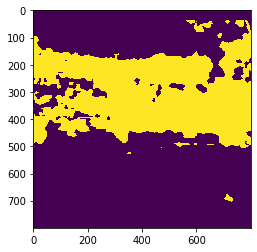

0.6323760041624077
Random TS: 
0.25573449214104


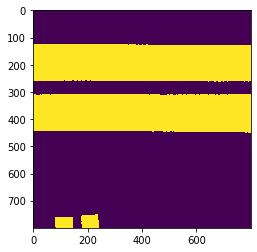

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


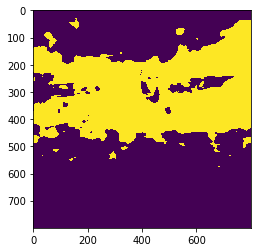

0.6468795110977584
Random TS: 
0.26246914944561095


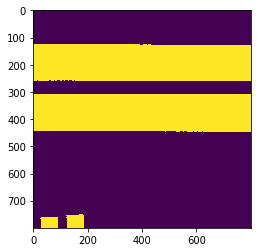

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


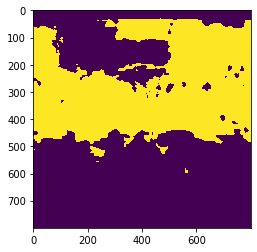

0.5282091630605147
Random TS: 
0.2953048501285619


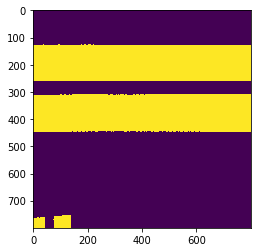

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


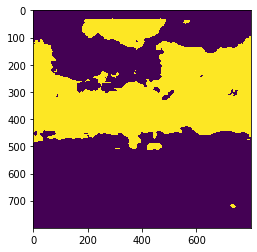

0.5618728981275171
Random TS: 
0.2663376110562685


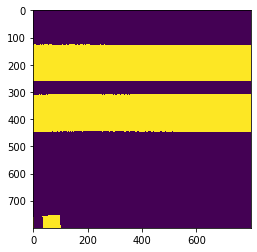

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


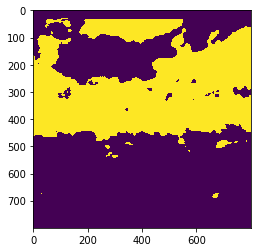

0.5368346434680742
Random TS: 
0.27608554175614114


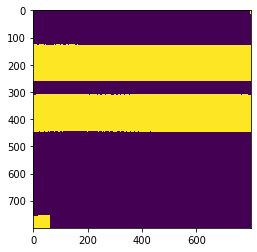

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


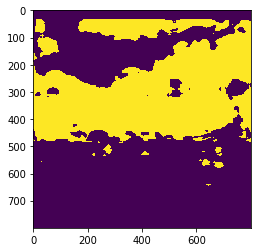

0.5231184632364535
Random TS: 
0.27640613949662995


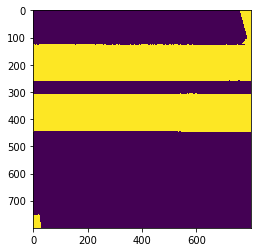

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


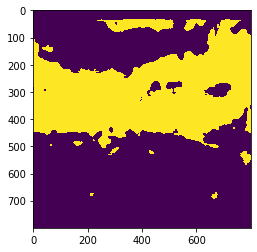

0.5830098020372861
Random TS: 
0.2665601181358746


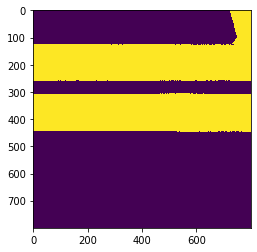

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


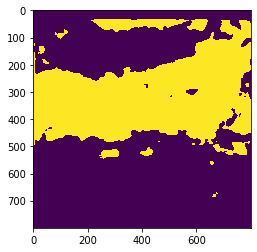

0.5359236903789584
Random TS: 
0.27227853519484896


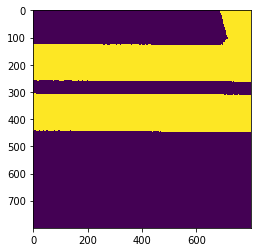

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


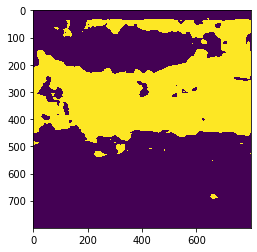

0.5607162804867728
Random TS: 
0.266108740587289


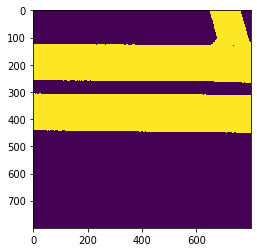

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


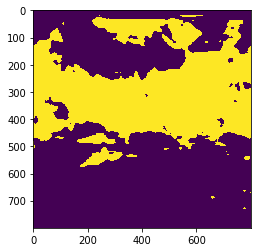

0.5044704772387766
Random TS: 
0.27852687745610555


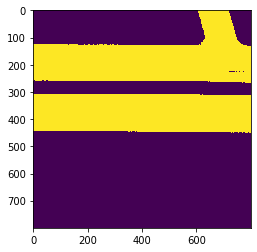

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


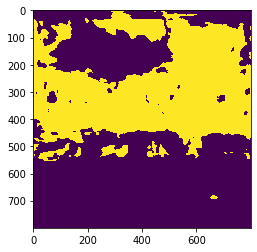

0.5197964144636888
Random TS: 
0.29661552277044234


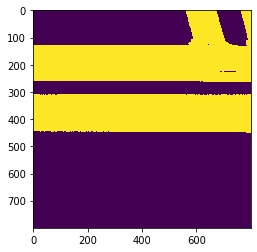

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


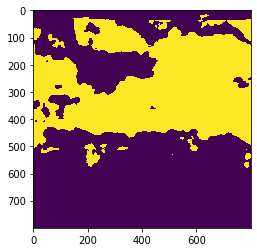

0.5672368900859174
Random TS: 
0.28455115754693816


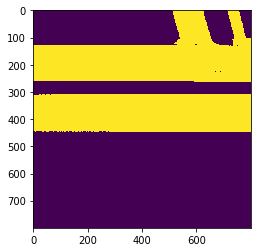

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


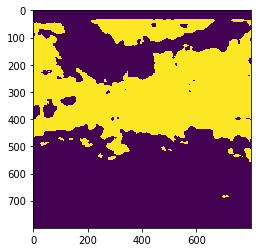

0.5192532125190467
Random TS: 
0.27879709531993774


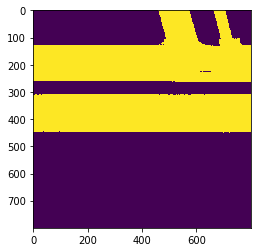

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


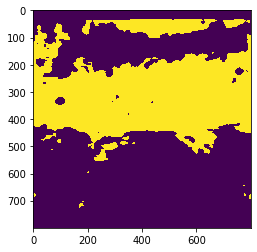

0.5397597235667074
Random TS: 
0.27413785666774876


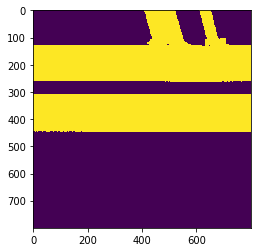

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


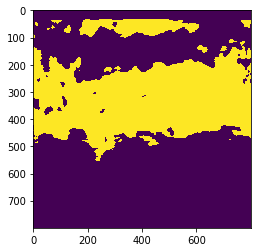

0.5156458746773545
Random TS: 
0.2633464980114892


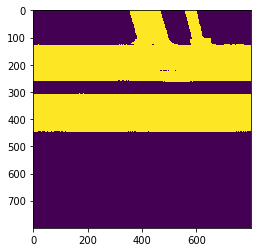

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


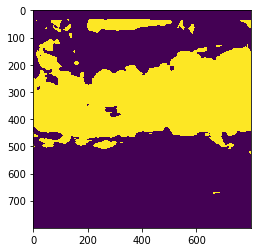

0.5456688448274725
Random TS: 
0.2638503072224879


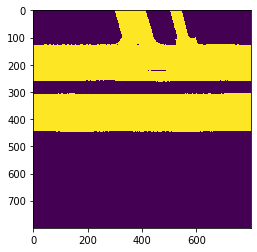

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


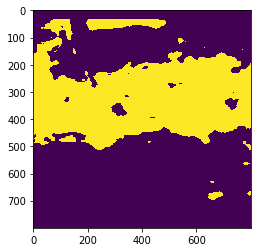

0.5173615318362976
Random TS: 
0.26020058844210875


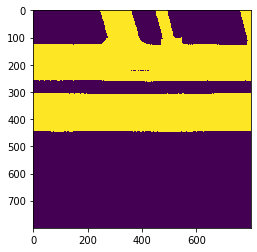

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


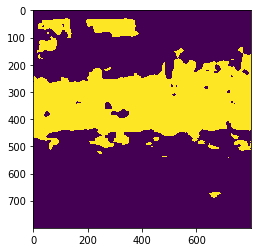

0.4683042526371658
Random TS: 
0.23938580678346308


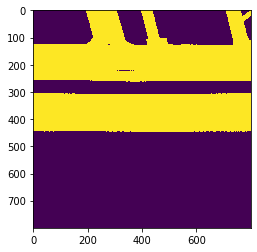

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


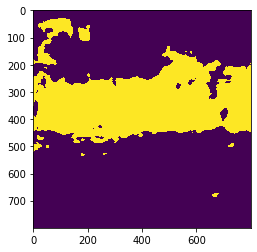

0.4536566772434408
Random TS: 
0.22720090457069134


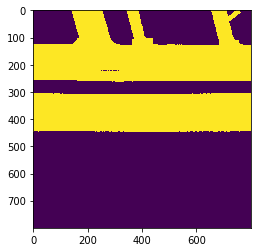

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


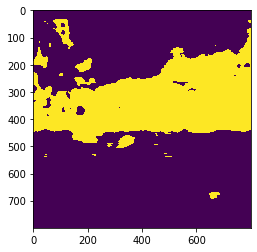

0.511169204807945
Random TS: 
0.22816009575243362


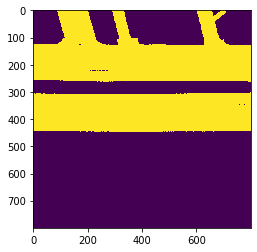

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


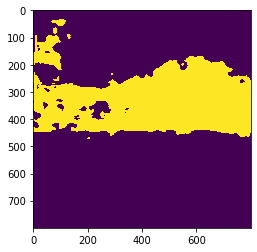

0.4652325266881413
Random TS: 
0.20980384414148495


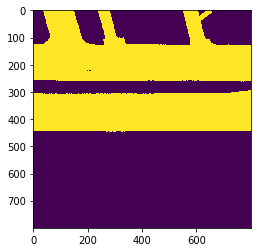

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


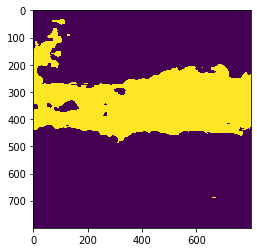

0.453062630010682
Random TS: 
0.20567234977834623


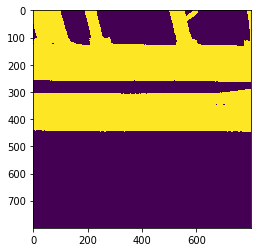

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


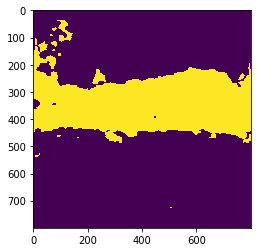

0.45287650911826055
Random TS: 
0.20798525646575716


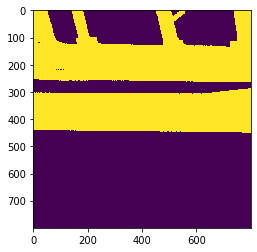

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


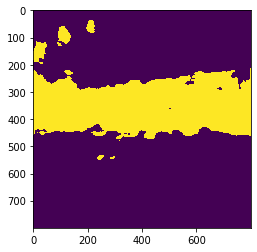

0.428135918575907
Random TS: 
0.20316915271638103


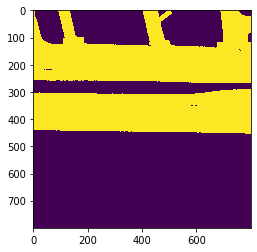

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


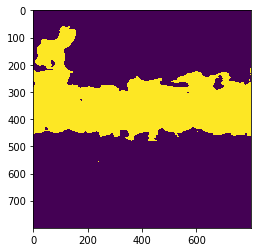

0.48045457417013543
Random TS: 
0.20919759757981335


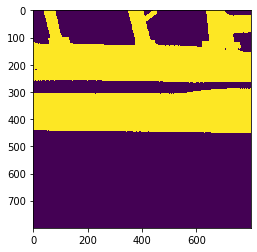

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


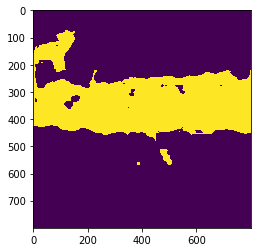

0.4620895418222424
Random TS: 
0.20613052698494683


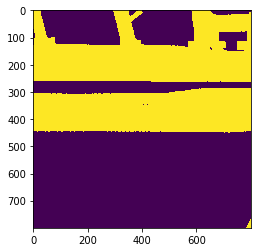

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


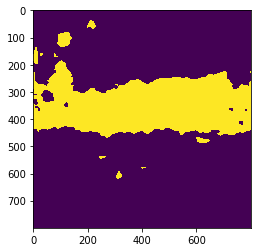

0.42831435174871907
Random TS: 
0.19143346254700117


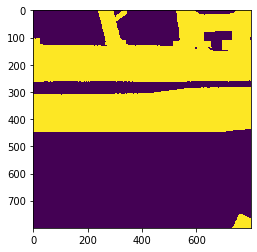

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


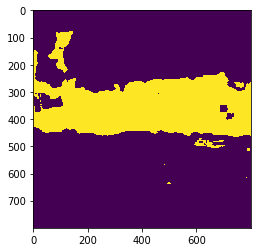

0.40998482518408375
Random TS: 
0.191125684937563


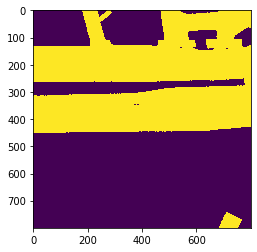

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


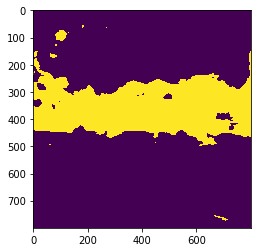

0.4069369809477284
Random TS: 
0.1886490523096618


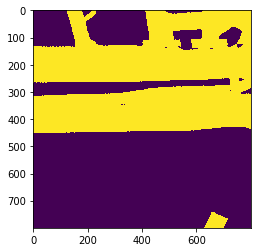

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


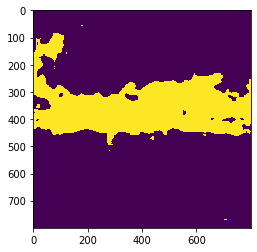

0.39307213293581084
Random TS: 
0.17958006271391388


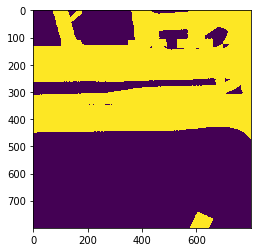

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


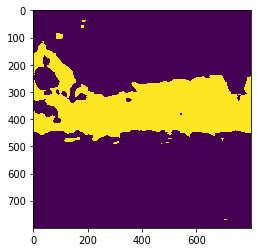

0.40234928889310967
Random TS: 
0.18346739208100687


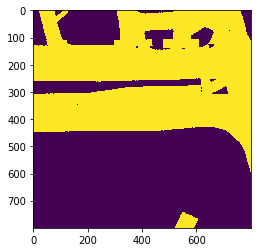

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


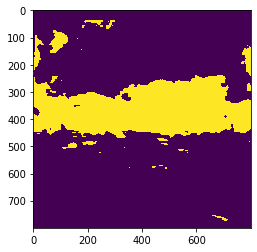

0.3827941710478536
Random TS: 
0.18129863751016878


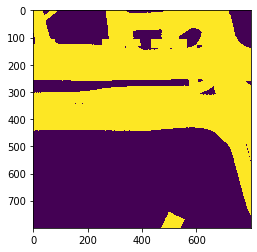

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


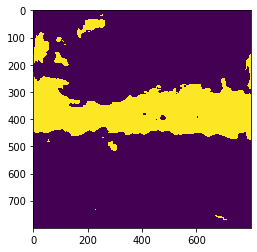

0.35208316100035847
Random TS: 
0.17187520232875542


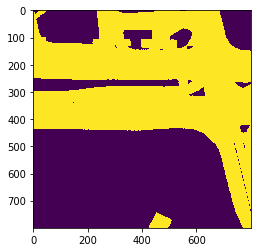

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


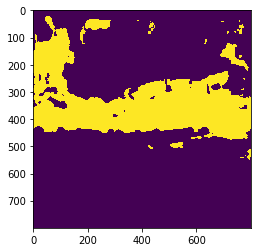

0.4050821636172699
Random TS: 
0.1955925287558479


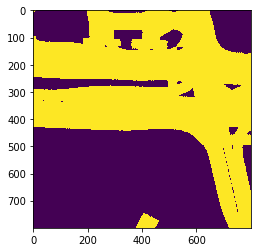

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


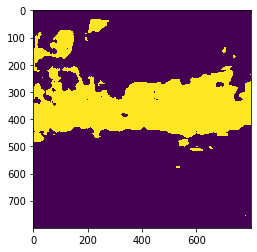

0.39661901187487236
Random TS: 
0.19571780947165887


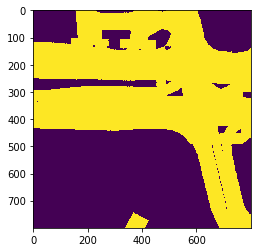

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


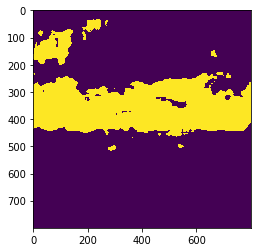

0.3793308482173485
Random TS: 
0.18845653315474242


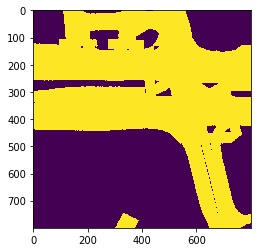

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


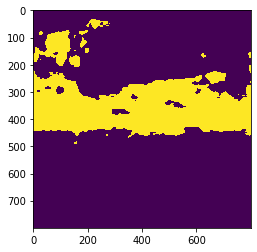

0.3767777910678992
Random TS: 
0.18719638830775645


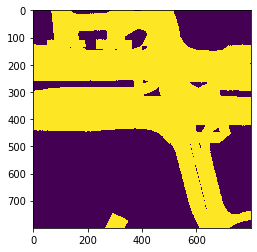

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


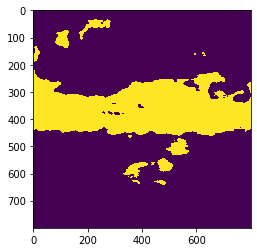

0.3640819826095785
Random TS: 
0.18590318014724602


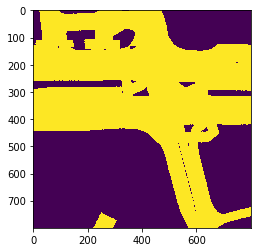

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


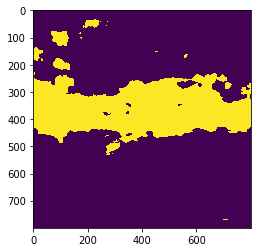

0.3662777627911159
Random TS: 
0.18790959042865904


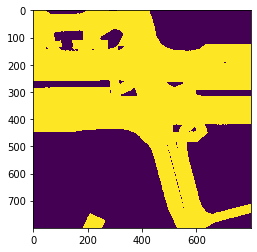

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


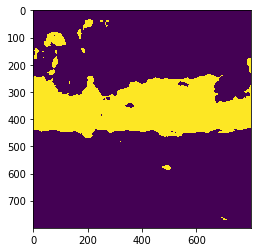

0.36258273434521066
Random TS: 
0.18046616802922247


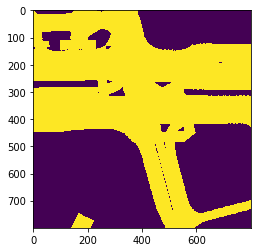

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


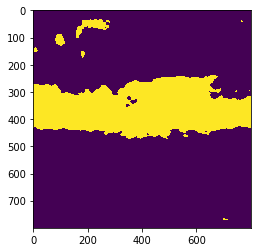

0.36328062725546745
Random TS: 
0.177398089253985


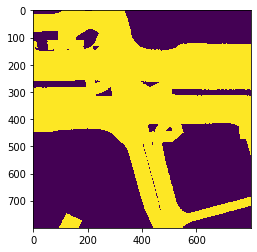

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


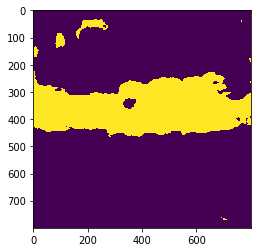

0.35899991862641384
Random TS: 
0.17633539653330932


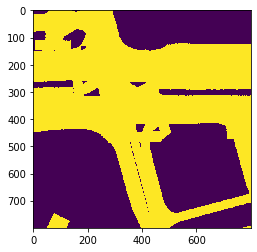

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


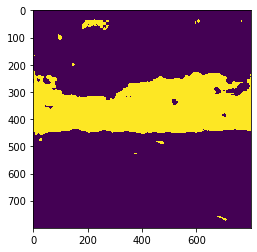

0.3479747523539402
Random TS: 
0.18043806782174535


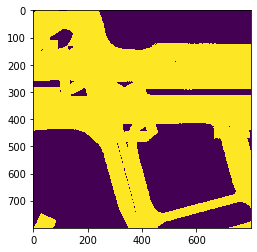

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


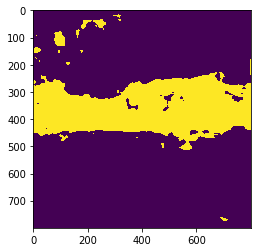

0.31602594238823833
Random TS: 
0.18399408111014778


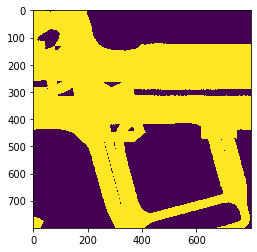

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


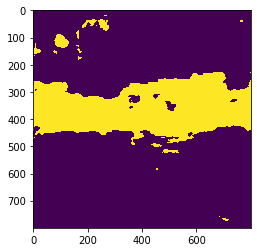

0.315513758645138
Random TS: 
0.18382860915739804


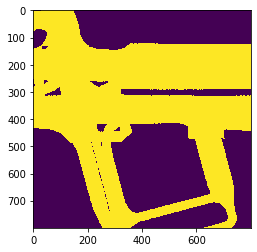

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


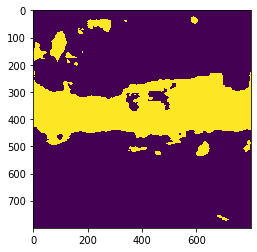

0.32280790510430346
Random TS: 
0.1898332310443328


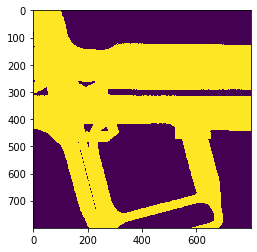

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


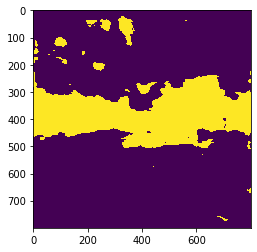

0.29784071561765263
Random TS: 
0.18206970619070756


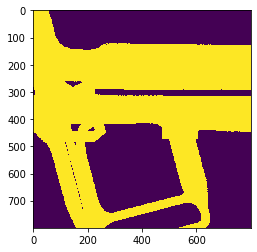

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


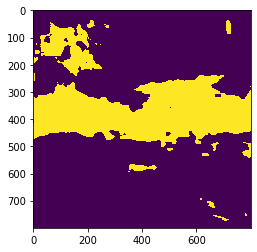

0.34044759424218424
Random TS: 
0.20109121586206552


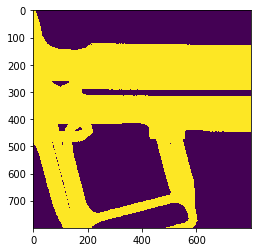

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


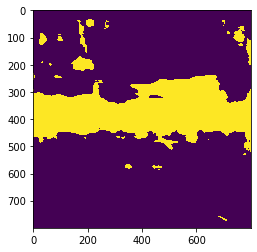

0.336759369495145
Random TS: 
0.18428625684710656


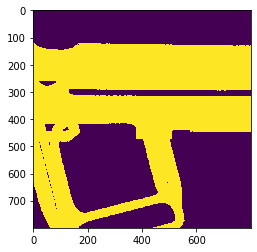

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


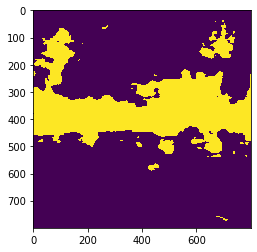

0.36368728563795866
Random TS: 
0.1998972430202571


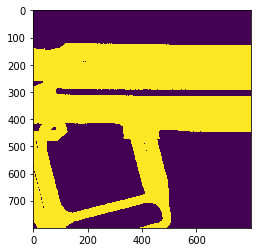

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


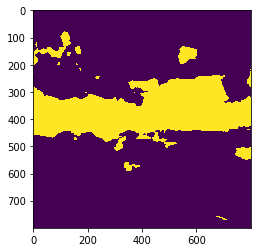

0.35397646799144067
Random TS: 
0.17924179665244908


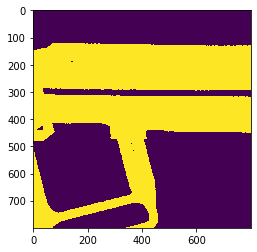

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


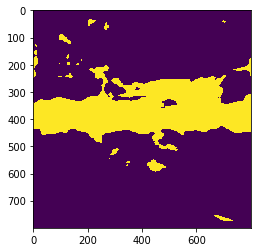

0.3523044748993816
Random TS: 
0.17286495691212136


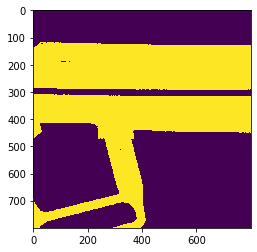

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


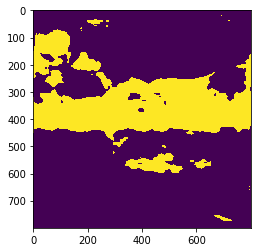

0.42655185206881063
Random TS: 
0.2035549147317655


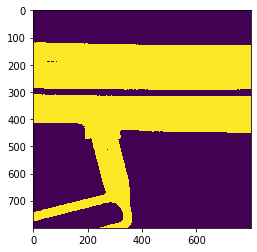

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


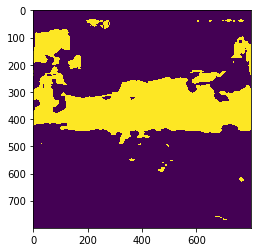

0.4086072055796398
Random TS: 
0.187920554572991


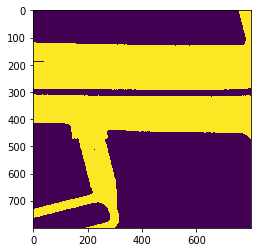

tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


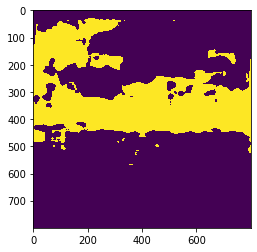

0.4522474159441133
Random TS: 


100%|██████████| 1/1 [41:12<00:00, 2472.05s/it]

0.21752020508404923


In [7]:
def main():
    
    image_folder = '../../data'
    annotation_csv = '../../data/annotation.csv'
    trainloader, valloader = LoadData(image_folder, annotation_csv)
    sample, target, road_image, extra = iter(trainloader).next()
    #print(road_image)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = "cpu"
    model = SEncoder_Decoder()
    model.to(device)
    if model_avail:
        model.load_state_dict(torch.load(model_path,map_location=lambda storage, location: storage))
    else:
        model.apply(weight_init)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    if is_eval:
        model.eval()
        num_epochs = 1
        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            data_len = len(valloader)
            for i, data in enumerate(valloader, 0):
                sample, target, road_image, extra  = data
                outputs = model(torch.stack(sample).to(device))
                outputs = torch.squeeze(outputs)
                road_image_true = torch.stack([torch.Tensor(x.numpy()) for x in road_image]).to(device)
                plt.imshow(road_image_true[0].numpy())
                plt.show()
                #loss = criterion(outputs, road_image_true) + 10*criterion(outputs*road_image_true, road_image_true)
                #outputs.clamp(0,1)
                #_, predicted = torch.max(outputs.data, 0)
                #outputs = predicted
                outputs = outputs>=0.5
                print(outputs[0].min(), outputs[0].max())
                plt.imshow(outputs[0].detach().numpy())
                plt.show()
                print(ThreatScore(road_image_true[0],outputs[0]))
                print("Random TS: "),
                random_map = torch.randint(0,2,(800,800))
                print(ThreatScore(random_map,outputs[0]))
    else:
        
        num_epochs = 150
        model.train()

        for epoch in tqdm(range(num_epochs)):
            running_loss = 0.0
            data_len = len(trainloader)
            for i, data in enumerate(trainloader, 0):
                sample, target, road_image, extra  = data
                optimizer.zero_grad()
                outputs = model(torch.stack(sample).to(device))
                outputs = torch.squeeze(outputs)
                road_image_true = torch.stack([torch.Tensor(x.numpy()) for x in road_image]).to(device)
                loss = criterion(outputs, road_image_true) + 10*criterion(outputs*road_image_true, road_image_true)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print('[%d, %5d] loss: %.3f' % (epoch + 1, num_epochs, running_loss / data_len))
            torch.save(model.state_dict(), 'model_'+str(epoch)+'.pth')

if __name__ == '__main__':
	main()
